# Prediction of Mutation Effect: Minimizing the impact of randomization
## Single Protein Multiple Mutation


<b><i class="fa fa-folder-o" area-hidden="true" style="color:#1976D2"> </i>&nbsp; File Location</b><br>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">C:\Users\ibrah\Documents\GitHub\Predicting-Mutation-Effects\src</code>
</p>

<b><i class="far fa-file" area-hidden="true" style="color:#1976D2"> </i>&nbsp; File Name</b>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">Minimize_randomization_25.ipynb</code>
</p>

<b><i class="far fa-calendar-alt" area-hidden="true" style="color:#1976D2"> </i>&nbsp; Last Edited</b>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">August 24th, 2021</code>
</p>


<div class="alert alert-block" style="background-color: #F5F5F5; border: 1px solid; padding: 10px; border-color: #E0E0E0">
    <b><i class="fa fa-compass" aria-hidden="true" style="color:#404040"></i></b>&nbsp; <b style="color: #404040">Purpose </b> <br>
<div>

    
- [x] $\textit{mutation effect label}$ prediction using Random Forest algorithm.
    

- [x] Classification will be $\textit{Disrupting vs (No effect + Increasing)}$.
    > $\textit{Disrupting} → 0$\
    > $\textit{No effect + Increasing} → 1$\
    > $\textit{Decreasing} → \textit{ignored}$
    
    
- [x] Evaluate the performane of the model.
    
- [x] We use SHAP in feature selection
    
    
- [x] Apply on Cancer Datasets
    > For now, a portion of all BRCA. But will be updated.
     
- [ ] We measure the impact of randomization by repeating whole experiment with multiple runs. 
    
**Dependent files:**
* Training (mutations) data:
    - *training_data_M1.txt*


* Target (Cancer) data: 
    - *BRCA_INTERFACE_A2.txt*

## Setup

In [9]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import random
from IPython.display import display
from tqdm.notebook import tqdm
from helpers.common import print_annotation, get_file_path
from helpers.displayers import display_label_counts, display_labels, visualize_label_counts
from helpers.construct_data import prepare_data_spsm, prepare_data_spmm

NUM_EXPERIMENT_REPEAT = 50

SEED = 42
random.seed(SEED)
random_seeds = random.sample(range(1, 99999), NUM_EXPERIMENT_REPEAT)

# PATHS
PROJECT_COMMON_FILE_DIR = "../data/"
MUTATIONS_PATH = "training_data_M1.txt"
INITIAL_COLUMNS_PATH = "../data/initial_columns_59.csv"
BRCA_PATH = "../data/BRCA_INTERFACE_A2.txt"

# Reflect changes in the modules immediately.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading the Datasets

### 1. Training Data: Mutations

In [10]:
# Read Training Data
mutations = pd.read_csv(get_file_path(PROJECT_COMMON_FILE_DIR, MUTATIONS_PATH), sep='\t')

# Size of dataframe
print_annotation(f"Size of dataframe: {mutations.shape}")

# First 5 entries
mutations.head()


Size of dataframe: (1101, 104)
------------------------------


,Mutation_Effect_Label,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
1,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
2,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
3,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
4,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627


### 2. TCGA Data

Cancer datasets whose feature columns have been collected from ELASPIC.

**BRCA**

In [11]:
# Read BRCA Data
brca = pd.read_csv(get_file_path(PROJECT_COMMON_FILE_DIR, BRCA_PATH), sep='\t')

# Size of dataframe
print_annotation(f"Size of dataframe: {brca.shape}")

# First 3 entries
brca.head(3)


Size of dataframe: (4452, 103)
------------------------------


,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,Domain_clan,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


**COAD** // to be added

**OV** // to be added

## Data Cleaning

### Select column names

In [12]:
initial_columns_train = pd.read_csv(INITIAL_COLUMNS_PATH)['0'].to_list()
# ['Mutation_Effect_Label'] + ['UniProt_ID', 'Mutation', 'Interactor_UniProt_ID'] + remaining feature list
initial_columns_train_with_protein_mutation_interactor = [initial_columns_train[0]] + ['UniProt_ID', 'Mutation', 'Interactor_UniProt_ID'] + initial_columns_train[1:]

In [13]:
initial_columns_target = initial_columns_train.copy()
initial_columns_target.remove('Mutation_Effect_Label')

In [14]:
initial_columns_train_with_protein_mutation_interactor

['Mutation_Effect_Label',
 'UniProt_ID',
 'Mutation',
 'Interactor_UniProt_ID',
 'Template_sequence_identity',
 'Alignment_score',
 'Interactor_template_sequence_identity',
 'Interactor_alignment_score',
 'Final_ddG',
 'ProtBert_score',
 'ProteinSolver_score',
 'EL2_score',
 'Model/DOPE_score',
 'Provean_score',
 'Matrix_score',
 'Solvent_accessibility_wt',
 'Solvent_accessibility_mut',
 'pcv_vdW_wt',
 'pcv_vdW_mut',
 'pcv_vdW_self_wt',
 'pcv_vdW_self_mut',
 'dg_wt',
 'backbone_hbond_wt',
 'sidechain_hbond_wt',
 'van_der_waals_wt',
 'electrostatics_wt',
 'solvation_polar_wt',
 'solvation_hydrophobic_wt',
 'van_der_waals_clashes_wt',
 'entropy_sidechain_wt',
 'entropy_mainchain_wt',
 'torsional_clash_wt',
 'backbone_clash_wt',
 'helix_dipole_wt',
 'electrostatic_kon_wt',
 'energy_ionisation_wt',
 'number_of_residues_wt',
 'dg_mut',
 'backbone_hbond_mut',
 'sidechain_hbond_mut',
 'van_der_waals_mut',
 'electrostatics_mut',
 'solvation_polar_mut',
 'solvation_hydrophobic_mut',
 'van_der_w

### Reduce Columns

#### Train (Mutations) Data

In [15]:
# Declare train data using selected column names
train_data = mutations[initial_columns_train_with_protein_mutation_interactor].copy()

# Size of dataframe
print_annotation(f"Size of dataframe: {train_data.shape}")

# First 5 entries
train_data.head()


Size of dataframe: (1101, 62)
-----------------------------


,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,mutation decreasing rate(MI:1130),P63000,Q61L,Q14155,1.0,0.921875,0.2432,0.253076,1.72835,0.9981741060182685,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
1,mutation decreasing rate(MI:1130),P63000,Q61L,Q14155-1,1.0,0.921875,0.2432,0.253076,1.72835,0.9981741060182685,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
2,mutation decreasing rate(MI:1130),P63000,Q61L,Q14155-2,1.0,0.921875,0.2432,0.253076,1.72835,0.9981741060182685,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
3,mutation decreasing rate(MI:1130),P63000,Q61L,Q14155-3,1.0,0.921875,0.2432,0.253076,1.72835,0.9981741060182685,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
4,mutation decreasing rate(MI:1130),P63000,Q61L,Q14155-5,1.0,0.921875,0.2432,0.253076,1.72835,0.9981741060182685,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627


In [16]:
# Dropping the duplicates
train_data.drop_duplicates(keep="first", inplace=True)

Ensuring that there is no duplicated row.

In [17]:
train_data[train_data.duplicated()].empty  # True, duplicate is empty

True

In [18]:
train_data.shape

(1101, 62)

#### Target (Cancer) Data

**BRCA**

In [19]:
# Declare target_brca data using selected column names
target_brca_data = brca[initial_columns_target].copy(deep=True)

# Size of dataframe
print_annotation(f"Size of dataframe: {target_brca_data.shape}")

# First 3 entries
target_brca_data.head(3)


Size of dataframe: (4452, 58)
-----------------------------


,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0.5343,0.530760,0.9857,0.936088,0.730056,0.957609918201342,0.741487597115338,1.76123535329794,-1.137780,-4.726,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,0.5884,0.579682,0.9928,0.993160,0.795178,0.927518657408655,0.0195063538849354,1.12969519749536,-0.929739,-4.726,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,0.5884,0.579682,0.9928,0.993160,1.03054,0.927518657408655,0.0146090686321259,1.27036083414174,-0.896799,-4.726,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


## Data Preprocessing

* [x] Not all selected columns are interpreted as numeric, so coerce them to numeric.

### Mutation Effect Label Binning

Mutation Effect label binning is only applied to train_data.

* [x] Apply Label binning.
    > $\textit{Disruptive} → 0$\
    > $\textit{No effect + Increasing} → 1$\
    > $\textit{Decreasing} → \textit{ignored}$


For $\textit{mutation effect label}$ we have following categories:

In [20]:
# Displaying possible label categories.
display_labels(train_data)

,Mutation_Effect_Label
0,mutation disrupting(MI:0573)
1,mutation decreasing(MI:0119)
2,mutation disrupting strength(MI:1128)
3,mutation decreasing strength(MI:1133)
4,mutation with no effect(MI:2226)
5,disrupting
6,mutation increasing(MI:0382)
7,mutation increasing strength(MI:1132)
8,mutation decreasing rate(MI:1130)
9,mutation disrupting rate(MI:1129)


Applying binning operation on $\textit{mutation effect label}$ column in $\textit{mutations}$ data with described rule below \
    - $\textit{Disrupting} → 0$\
    - $\textit{No effect + Increasing} → 1$\
    - $\textit{Decreasing} → \textit{dropped}$\
    - $\textit{Causing} → \textit{dropped}$\
yields following data frame:

In [21]:
labels_to_bins = { 
    "mutation disrupting(MI:0573)": 0,
    "mutation decreasing(MI:0119)": "IGNORED",
    "mutation disrupting strength(MI:1128)": 0,
    "mutation decreasing strength(MI:1133)": "IGNORED",
    "mutation with no effect(MI:2226)": 1,
    "disrupting": 0,
    "mutation increasing(MI:0382)": 1,
    "mutation increasing strength(MI:1132)": 1,
    "mutation decreasing rate(MI:1130)": "IGNORED",
    "mutation disrupting rate(MI:1129)": 0,
    "mutation causing(MI:2227)": "IGNORED",
    "mutation increasing rate(MI:1131)": 1}

replace_map = {"Mutation_Effect_Label": labels_to_bins}

In [22]:
# Size of dataframe before binning.
print_annotation(f"Size of dataframe before binning: {train_data.shape}")

# Modifications will be done on train_data_binned.
train_data_binned = train_data.copy()

# Replace the labels as described above.
train_data_binned.replace(replace_map, inplace=True)

# Drop the entries with "IGNORED": 'mutation cusing' in this case.
train_data_binned = train_data_binned[train_data_binned["Mutation_Effect_Label"] != "IGNORED"]

# Reset index of the dataframe to avoid any possible errors
train_data_binned.reset_index(drop=True, inplace=True)

# Size of dataframe after binning.
print_annotation(f"Size of dataframe after binning: {train_data_binned.shape}")

# First 5 rows of binned data.
train_data_binned.head()


Size of dataframe before binning: (1101, 62)
--------------------------------------------

Size of dataframe after binning: (740, 62)
------------------------------------------


,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.219700,-0.09227252565324306,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749150385265,...,329.0,47.61770,47.21160,70.2902,70.2461,464.47,400.03,864.505,3.07827,3.59123
2,0,Q96QK1,F534D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.695710,0.2882971949657076,...,453.0,68.21080,68.19710,59.2321,59.1774,510.69,298.82,809.51,3.03938,3.24435
3,0,Q96QK1,F534D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,2.695710,0.2882971949657076,...,453.0,68.21080,68.19710,59.2321,59.1774,510.69,298.82,809.51,3.03938,3.24435
4,0,O43521-3,G66A,Q07812,1.0000,0.714286,0.3007,0.222028,0.683334,-0.051025405526161194,...,202.0,3.74828,3.76142,41.5937,41.5937,405.51,273.74,679.245,3.37301,3.22505


Confirming replacement of values are properly done. $\textit{Mutation_Effect_Label}$ only contains of $0$ or $1$.

In [23]:
train_data_binned["Mutation_Effect_Label"].value_counts()

0    540
1    200
Name: Mutation_Effect_Label, dtype: int64

In [24]:
set(train_data_binned["Mutation_Effect_Label"].value_counts().index)

{0, 1}

### Type Coercion

Some columns have been interpreted as `object` type, eventhough they are actually numeric.

In [25]:
# Train (mutations) data
set(train_data_binned.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [26]:
# Target Cancer data
set(target_brca_data.dtypes), # set(target_coad_data.dtypes), set(target_ov_data.dtypes)

({dtype('int64'), dtype('float64'), dtype('O')},)

These non-numeric interpereted columns will be coerced. $\textit{NaN}$ values will be converted to $0$.

In [27]:
features = [column for column in train_data_binned.columns if column not in ['UniProt_ID', 'Mutation', 'Interactor_UniProt_ID']]

In [28]:
features_brca = [column for column in target_brca_data.columns if column not in ['UniProt_ID', 'Mutation', 'Interactor_UniProt_ID']]

In [29]:
# Get column names where its type is *not* int or float, i.e. whose type is object.
coerce_numeric_cols = set([cname for cname in features if train_data_binned[cname].dtype not in ['int64', 'float64']]
                        + [cname for cname in features_brca if target_brca_data[cname].dtype not in ['int64', 'float64']]) # \ 
#                         + [cname for cname in target_coad_data.columns if target_coad_data[cname].dtype not in ['int64', 'float64']]\
#                         + [cname for cname in target_ov_data.columns if target_ov_data[cname].dtype not in ['int64', 'float64']])

# Remove target variable from the list
coerce_numeric_cols = coerce_numeric_cols - {"Mutation_Effect_Label", "UniProt_ID", "Mutation", "Interactor_UniProt_ID"}

for cname in coerce_numeric_cols:
    train_data_binned[cname] = pd.to_numeric(train_data_binned[cname], errors='coerce')
    target_brca_data[cname] = pd.to_numeric(target_brca_data[cname], errors='coerce')
#     target_coad_data[cname] = pd.to_numeric(target_coad_data[cname], errors='coerce')
#     target_ov_data[cname] = pd.to_numeric(target_ov_data[cname], errors='coerce')
    
train_data_binned.fillna(0, inplace=True)
target_brca_data.fillna(0, inplace=True)
# target_coad_data.fillna(0, inplace=True)
# target_ov_data.fillna(0, inplace=True)

Now all columns are interpreted as numeric type, except "_UniProt_ID_", "_Mutation_", "_Interactor_UniProt_ID_"

In [30]:
# Train (mutations) data
set(train_data_binned.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [31]:
# Target Cancer data
set(target_brca_data.dtypes), # set(target_coad_data.dtypes), set(target_ov_data.dtypes)

({dtype('int64'), dtype('float64')},)

In [32]:
# all features are numeric.
train_data_binned.dtypes[features]

Mutation_Effect_Label                      int64
Template_sequence_identity               float64
Alignment_score                          float64
Interactor_template_sequence_identity    float64
Interactor_alignment_score               float64
Final_ddG                                float64
ProtBert_score                           float64
ProteinSolver_score                      float64
EL2_score                                float64
Model/DOPE_score                         float64
Provean_score                            float64
Matrix_score                             float64
Solvent_accessibility_wt                 float64
Solvent_accessibility_mut                float64
pcv_vdW_wt                                 int64
pcv_vdW_mut                                int64
pcv_vdW_self_wt                            int64
pcv_vdW_self_mut                           int64
dg_wt                                    float64
backbone_hbond_wt                        float64
sidechain_hbond_wt  

In [33]:
# all features are numeric.
set(train_data_binned.dtypes[features].values)

{dtype('int64'), dtype('float64')}

In [34]:
# all features are numeric.
target_brca_data.dtypes[features_brca]

Template_sequence_identity               float64
Alignment_score                          float64
Interactor_template_sequence_identity    float64
Interactor_alignment_score               float64
Final_ddG                                float64
ProtBert_score                           float64
ProteinSolver_score                      float64
EL2_score                                float64
Model/DOPE_score                         float64
Provean_score                            float64
Matrix_score                             float64
Solvent_accessibility_wt                 float64
Solvent_accessibility_mut                float64
pcv_vdW_wt                                 int64
pcv_vdW_mut                                int64
pcv_vdW_self_wt                            int64
pcv_vdW_self_mut                           int64
dg_wt                                    float64
backbone_hbond_wt                        float64
sidechain_hbond_wt                       float64
van_der_waals_wt    

### Processed train data and Label Counts

From now on, training data is refered as `data_processed`.

In [35]:
# Declaing `data_processed`.
data_processed = train_data_binned.copy()

# Size of processed data.
print_annotation(f"Size of processed data: {data_processed.shape}")

# First 5 rows of binned data.
data_processed.head()


Size of processed data: (740, 62)
---------------------------------


,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,0,Q96QK1,F534D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.695710,0.288297,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
3,0,Q96QK1,F534D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,2.695710,0.288297,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
4,0,O43521-3,G66A,Q07812,1.0000,0.714286,0.3007,0.222028,0.683334,-0.051025,...,202.0,3.74828,3.76142,41.5937,41.5937,405.510,273.740,679.245,3.37301,3.22505


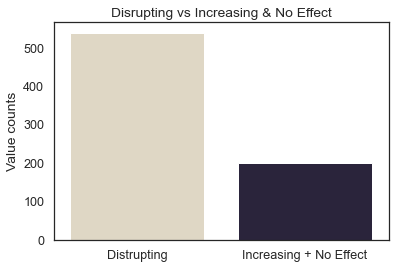

In [36]:
visualize_label_counts(data_processed)

In [37]:
display_label_counts(data_processed)

,Mutation_Effect_Label,Counts
Disrupting,0,540
Increasing + No Effect,1,200


In [83]:
from Predator import Predator

In [84]:
predator = Predator(project_common_file_dir=PROJECT_COMMON_FILE_DIR, 
                    mutations_path=MUTATIONS_PATH, 
                    tcga_code_path_pairs=[('brca', BRCA_PATH)],
                    initial_columns_path=INITIAL_COLUMNS_PATH, 
                    n_experiment=50)

In [85]:
predator.train_data.head(3)

,Mutation_Effect_Label,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
1,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
2,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627


In [86]:
predator.train_data_processed.head(3)

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.21970,-0.092273,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.07695,0.998749,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,0,Q96QK1,F534D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.69571,0.288297,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435


In [87]:
predator.brca.head(3)

,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,Domain_clan,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


In [88]:
predator.target_brca_data.head(3)

,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,Q9UKS6,R24H,Q9BY11,0.5343,0.530760,0.9857,0.936088,0.730056,0.957610,0.741488,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,Q9UKS6,R24H,Q9UNF0,0.5884,0.579682,0.9928,0.993160,0.795178,0.927519,0.019506,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,Q9UKS6,R24H,Q9UNF0-2,0.5884,0.579682,0.9928,0.993160,1.030540,0.927519,0.014609,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.300,2331.75,3.55240,4.79224


In [89]:
assert predator.train_data.equals(mutations)
assert predator.train_data_processed.equals(data_processed)
assert predator.brca.equals(brca)
assert predator.target_brca_data.drop(['UniProt_ID', 'Mutation', 'Interactor_UniProt_ID'], 1).equals(target_brca_data)

In [90]:
predator.train_data.equals(mutations)

True

In [91]:
predator.train_data_processed.equals(data_processed)

True

In [92]:
print(target_brca_data.shape)
target_brca_data.head()

(4452, 58)


,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0.5343,0.530760,0.9857,0.936088,0.730056,0.957610,0.741488,1.761235,-1.137780,-4.726,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,0.5884,0.579682,0.9928,0.993160,0.795178,0.927519,0.019506,1.129695,-0.929739,-4.726,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,0.5884,0.579682,0.9928,0.993160,1.030540,0.927519,0.014609,1.270361,-0.896799,-4.726,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.300,2331.75,3.55240,4.79224
3,0.5343,0.530760,0.9857,0.936088,0.324135,0.957610,0.464088,1.507389,-1.158870,-4.726,...,571.0,71.7108,71.2911,46.7150,46.6809,1491.81,704.155,2195.98,2.88254,3.23468
4,0.5884,0.579682,0.9928,0.993160,1.030540,0.927519,0.014609,1.270361,-0.896799,-4.726,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.300,2331.75,3.55240,4.79224


## Data Creation with Unique Proteins

In [94]:
predator.sample_spsm()

  0%|          | 0/50 [00:00<?, ?it/s]

In [66]:
len(predator.sampled_train_data_list)

50

In [149]:
# TODO: I could also use numpy array to store the sampled train dataframes
# because later on, one operation can be applied to each of them simultaneously. e.g. dropping column.
sampled_train_data_list = []
for i in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    sampled_train_data = prepare_data_spsm(data_processed, random_seed=i+1) # random_seeds[i]
    sampled_train_data_list.append(sampled_train_data)

  0%|          | 0/50 [00:00<?, ?it/s]

In [150]:
len(sampled_train_data_list)

50

In [151]:
sampled_train_data_to_label_counts = {}
for i, sampled_train_data in enumerate(sampled_train_data_list):
    label_counts = sampled_train_data['Mutation_Effect_Label'].value_counts()
    sampled_train_data_to_label_counts["SAMPLED_TRAIN_DATA_" + str(i+1)] = [label_counts.loc[0], label_counts.loc[1]]

In [152]:
experiment_statistics_data = pd.DataFrame(sampled_train_data_to_label_counts).T
experiment_statistics_data.columns = ['Disrupting', 'Increasing+NoEff']
experiment_statistics_data.index.name = 'SAMPLED_TRAIN_DATA'
experiment_statistics_data.reset_index(inplace=True)
experiment_statistics_data.head()

,SAMPLED_TRAIN_DATA,Disrupting,Increasing+NoEff
0,SAMPLED_TRAIN_DATA_1,102,62
1,SAMPLED_TRAIN_DATA_2,102,62
2,SAMPLED_TRAIN_DATA_3,104,60
3,SAMPLED_TRAIN_DATA_4,105,59
4,SAMPLED_TRAIN_DATA_5,104,60


In [153]:
experiment_statistics_data_melted = pd.melt(experiment_statistics_data, id_vars=['SAMPLED_TRAIN_DATA'], 
                                     value_vars=['Disrupting', 'Increasing+NoEff'],
                                     var_name='MUTATION_EFFECT', value_name='LABEL_COUNT')
experiment_statistics_data_melted.head()

,SAMPLED_TRAIN_DATA,MUTATION_EFFECT,LABEL_COUNT
0,SAMPLED_TRAIN_DATA_1,Disrupting,102
1,SAMPLED_TRAIN_DATA_2,Disrupting,102
2,SAMPLED_TRAIN_DATA_3,Disrupting,104
3,SAMPLED_TRAIN_DATA_4,Disrupting,105
4,SAMPLED_TRAIN_DATA_5,Disrupting,104


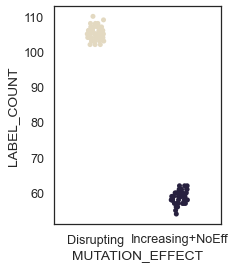

In [154]:
plt.figure(figsize=(3, 4))
sns.stripplot(x='MUTATION_EFFECT', y='LABEL_COUNT', data=experiment_statistics_data_melted, 
              palette='ch:s=-.2,r=.6', jitter=True);

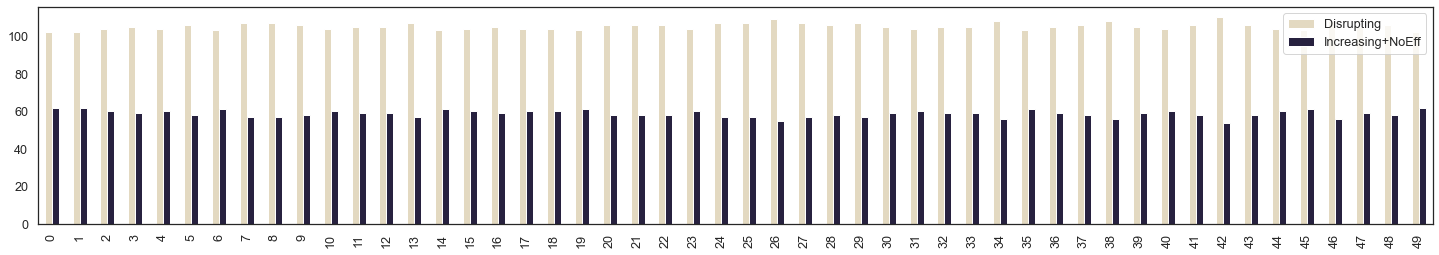

In [155]:
experiment_statistics_data.plot(figsize=(25, 4), kind='bar', color=['#E3D9C1', '#27213F']);

In [95]:
from helpers.visualizers import (
    visualize_sampled_train_datasets_label_counts_stripplot, visualize_sampled_train_datasets_label_counts_barplot
)

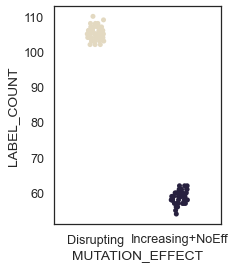

In [96]:
visualize_sampled_train_datasets_label_counts_stripplot(predator.sampled_train_data_list)

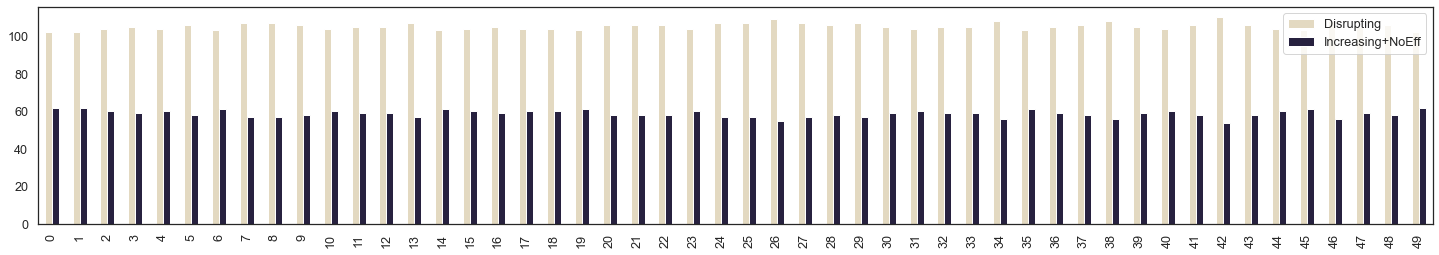

In [97]:
visualize_sampled_train_datasets_label_counts_barplot(predator.sampled_train_data_list)

## Prepare the Train Data for Machine Learning Algorithms

In [156]:
from helpers.prepare_data_for_ML import prepare_data_machine_learning

In [157]:
prepared_dataframes = []
label_proportions_dataframes = []
Xs = []
ys = []
Xs_train = []
ys_train = []
Xs_valid = []
ys_valid = []
Xs_train_random = []
ys_train_random = []
Xs_valid_random = []
ys_valid_random = []

for i in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    
    data_materials = prepare_data_machine_learning(sampled_train_data_list[i], random_seed=i+1)  # random_seeds[i]
    
    prepared_dataframes.append(data_materials['data_prepared'])
    label_proportions_dataframes.append(data_materials['label_proportions_data'])
    
    # All entries
    Xs.append(data_materials['X'])
    ys.append(data_materials['y'])

    # Stratified version
    Xs_train.append(data_materials['X_train'])
    ys_train.append(data_materials['y_train'])
    Xs_valid.append(data_materials['X_valid'])
    ys_valid.append(data_materials['y_valid'])

    # Randomized version
    Xs_train_random.append(data_materials['X_train_random'])
    ys_train_random.append(data_materials['y_train_random'])
    Xs_valid_random.append(data_materials['X_valid_random'])
    ys_valid_random.append(data_materials['y_valid_random'])


  0%|          | 0/50 [00:00<?, ?it/s]

In [136]:
predator.prepare_data_matarials_ML()

  0%|          | 0/50 [00:00<?, ?it/s]

In [158]:
for i in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    assert prepared_dataframes[i].equals(predator.data_materials_ML.prepared_dataframes[i])
    assert label_proportions_dataframes[i].equals(predator.data_materials_ML.label_proportions_dataframes[i])
    assert Xs[i].equals(predator.data_materials_ML.Xs[i])
    assert ys[i].equals(predator.data_materials_ML.ys[i])
    assert Xs_train[i].equals(predator.data_materials_ML.Xs_train[i])
    assert ys_train[i].equals(predator.data_materials_ML.ys_train[i])
    assert Xs_valid[i].equals(predator.data_materials_ML.Xs_valid[i])
    assert ys_valid[i].equals(predator.data_materials_ML.ys_valid[i])
    assert Xs_train_random[i].equals(predator.data_materials_ML.Xs_train_random[i])
    assert ys_train_random[i].equals(predator.data_materials_ML.ys_train_random[i])
    assert Xs_valid_random[i].equals(predator.data_materials_ML.Xs_valid_random[i])
    assert ys_valid_random[i].equals(predator.data_materials_ML.ys_valid_random[i])

  0%|          | 0/50 [00:00<?, ?it/s]

## Initial Insights

In [162]:
# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [163]:
from helpers.machine_learning_utils import cross_validation_options

In [38]:
for i in range(NUM_EXPERIMENT_REPEAT):
    # Initial scoring: X_train, y_train with prediction of X_valid
    forest_clf_inital = RandomForestClassifier(random_state=i)

    forest_clf_inital.fit(Xs_train[i], ys_train[i])

    forest_predictions = forest_clf_inital.predict(Xs_valid[i])
    
    print("-------- EXPERIMENT: {:>2} --------".format(i))
    print("Balanced accuracy score : {:.4f}".format(balanced_accuracy_score(ys_valid[i], forest_predictions)))
    print("Accuracy score\t\t: {:.4f}".format(accuracy_score(ys_valid[i], forest_predictions)))
    print("================================")

-------- EXPERIMENT:  0 --------
Balanced accuracy score : 0.6607
Accuracy score		: 0.7273
-------- EXPERIMENT:  1 --------
Balanced accuracy score : 0.5595
Accuracy score		: 0.5758
-------- EXPERIMENT:  2 --------
Balanced accuracy score : 0.8095
Accuracy score		: 0.8485
-------- EXPERIMENT:  3 --------
Balanced accuracy score : 0.6818
Accuracy score		: 0.7879
-------- EXPERIMENT:  4 --------
Balanced accuracy score : 0.6364
Accuracy score		: 0.7273
-------- EXPERIMENT:  5 --------
Balanced accuracy score : 0.6369
Accuracy score		: 0.6970
-------- EXPERIMENT:  6 --------
Balanced accuracy score : 0.5417
Accuracy score		: 0.5758
-------- EXPERIMENT:  7 --------
Balanced accuracy score : 0.6369
Accuracy score		: 0.6970
-------- EXPERIMENT:  8 --------
Balanced accuracy score : 0.7045
Accuracy score		: 0.7879
-------- EXPERIMENT:  9 --------
Balanced accuracy score : 0.7440
Accuracy score		: 0.7879
-------- EXPERIMENT: 10 --------
Balanced accuracy score : 0.5227
Accuracy score		: 0.6364

In [39]:
def evaluate_cross_val(X_train_param, y_train_param, cv_option_param):
        
    # Cross Validation options
    cv_option, n_jobs = cross_validation_options(cv_option_param, -1)
    
    # Model
    forest_clf = RandomForestClassifier(random_state=42)
    
    # Cross-validation Accuracy and Balanced Accuracy Scores
    forest_scores_bas = cross_val_score(forest_clf, 
                                        X_train_param, y_train_param,
                                        cv=cv_option, scoring="balanced_accuracy", n_jobs=n_jobs)

    forest_scores_as = cross_val_score(forest_clf, 
                                       X_train_param, y_train_param,
                                       cv=cv_option, scoring="accuracy", n_jobs=n_jobs)
    
    # Print scores and averages
    print("Balanced accuracy score AVG : {:.4f}".format(forest_scores_bas.mean()))
    # print(forest_scores_bas)
    print("Accuracy score AVG          : {:.4f}".format(forest_scores_as.mean()))
    # print(forest_scores_as)

In [41]:
for i in range(NUM_EXPERIMENT_REPEAT):
    print("---------- EXPERIMENT: {:>2} ----------".format(i))
    evaluate_cross_val(Xs[i], ys[i], "skf_10")
    print("====================================")

---------- EXPERIMENT:  0 ----------
Balanced accuracy score AVG : 0.6554
Accuracy score AVG          : 0.7265
---------- EXPERIMENT:  1 ----------
Balanced accuracy score AVG : 0.6386
Accuracy score AVG          : 0.6772
---------- EXPERIMENT:  2 ----------
Balanced accuracy score AVG : 0.7535
Accuracy score AVG          : 0.7849
---------- EXPERIMENT:  3 ----------
Balanced accuracy score AVG : 0.7153
Accuracy score AVG          : 0.7316
---------- EXPERIMENT:  4 ----------
Balanced accuracy score AVG : 0.6095
Accuracy score AVG          : 0.7199
---------- EXPERIMENT:  5 ----------
Balanced accuracy score AVG : 0.6487
Accuracy score AVG          : 0.7129
---------- EXPERIMENT:  6 ----------
Balanced accuracy score AVG : 0.6609
Accuracy score AVG          : 0.7088
---------- EXPERIMENT:  7 ----------
Balanced accuracy score AVG : 0.6482
Accuracy score AVG          : 0.7364
---------- EXPERIMENT:  8 ----------
Balanced accuracy score AVG : 0.6294
Accuracy score AVG          : 0.7213
-

## Shap Waterfall

In [164]:
# Import the package
import shap
shap.initjs()

In [165]:
def create_waterfall_plot(samples, X_param, y_param):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_param, y_param)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

    shap.summary_plot(shap_values[1], samples)

In [ ]:
create_waterfall_plot()

In [166]:
shap_values_train_list = []
for i in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    model = RandomForestClassifier(random_state=42)
    model.fit(Xs_train[i], ys_train[i])
    explainer = shap.TreeExplainer(model)
    shap_values_train_list.append(explainer.shap_values(Xs_train[i], approximate=False, check_additivity=False))

  0%|          | 0/50 [00:00<?, ?it/s]

In [189]:
def create_waterfall_plot(samples, X_param, y_param):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_param, y_param)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

    shap.summary_plot(shap_values[1], samples)

In [192]:
create_waterfall_plot(predator.data_materials_ML.Xs[0], predator.data_materials_ML.ys[0])  # num_display=11

TypeError: create_waterfall_plot() missing 1 required positional argument: 'y_param'

In [168]:
def get_shap_top_n_features(shap_values, features, n=10):
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    column_list = column_list[:n]

    return list(column_list)


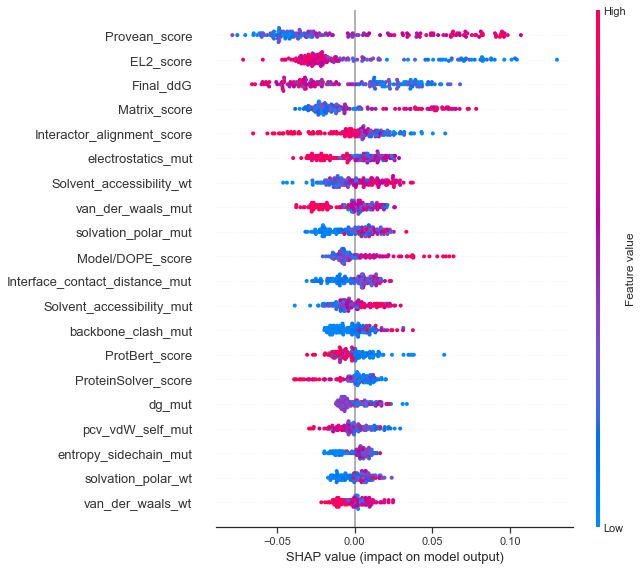

In [195]:
# Import the package
import shap
# shap.initjs()

model = RandomForestClassifier(random_state=42)
model.fit(predator.data_materials_ML.Xs[0], predator.data_materials_ML.ys[0])

# Let us have a look on SHAP summary plot

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(predator.data_materials_ML.Xs[0], approximate=False, check_additivity=False)

shap.summary_plot(shap_values[1], predator.data_materials_ML.Xs[0])

In [196]:
def make_shap_waterfall_plot(shap_values, features, num_display=20):
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))
    print(list(column_list))


['Provean_score', 'EL2_score', 'Final_ddG', 'Matrix_score', 'Interactor_alignment_score', 'electrostatics_mut', 'Solvent_accessibility_wt', 'van_der_waals_mut', 'solvation_polar_mut', 'Model/DOPE_score']


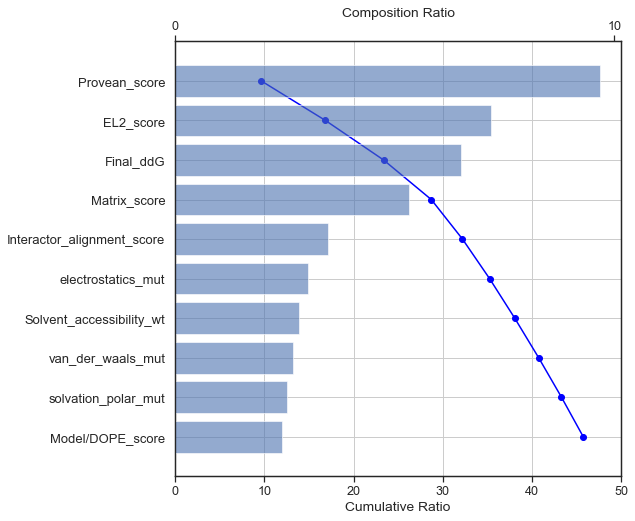

In [206]:
# Shap waterfall plot
make_shap_waterfall_plot(shap_values[1], predator.data_materials_ML.Xs[0], num_display=10)

In [169]:
Xs_train_shap = [None] * NUM_EXPERIMENT_REPEAT

# here, I selected top shap 10 for all. (i.e. n=10)
for i in range(len(Xs_train)):
    Xs_train_shap[i] = Xs_train[i][get_shap_top_n_features(shap_values_train_list[i][1], Xs_train[i], n=10)]

### Highly selected features by shap using 25 training sets

In [171]:
from collections import defaultdict

In [172]:
selected_features_to_occurrences = defaultdict(int)
for L in [list(data.columns) for data in Xs_train_shap]:
    for feature in L:
        selected_features_to_occurrences[feature] += 1

In [181]:
for L in [list(data.columns) for data in Xs_train_shap]:
    print(len(L), L, '\n')

10 ['Provean_score', 'EL2_score', 'Matrix_score', 'electrostatics_mut', 'Final_ddG', 'Interactor_alignment_score', 'Solvent_accessibility_mut', 'Model/DOPE_score', 'van_der_waals_mut', 'pcv_vdW_self_wt'] 

10 ['Provean_score', 'EL2_score', 'Final_ddG', 'solvation_polar_wt', 'entropy_mainchain_wt', 'sidechain_hbond_mut', 'Solvent_accessibility_mut', 'Solvent_accessibility_wt', 'van_der_waals_mut', 'Model/DOPE_score'] 

10 ['EL2_score', 'Final_ddG', 'Provean_score', 'Interface_contact_distance_mut', 'Interface_contact_distance_wt', 'entropy_sidechain_wt', 'Solvent_accessibility_mut', 'entropy_sidechain_mut', 'pcv_vdW_wt', 'Interactor_alignment_score'] 

10 ['EL2_score', 'Provean_score', 'Final_ddG', 'Interface_contact_distance_mut', 'entropy_sidechain_mut', 'Interactor_template_sequence_identity', 'van_der_waals_mut', 'Interface_contact_distance_wt', 'sidechain_hbond_wt', 'Model/DOPE_score'] 

10 ['EL2_score', 'Provean_score', 'Final_ddG', 'sidechain_hbond_mut', 'Solvent_accessibility_wt

In [173]:
selected_features_to_occurrences

defaultdict(int,
            {'Provean_score': 50,
             'EL2_score': 50,
             'Matrix_score': 34,
             'electrostatics_mut': 9,
             'Final_ddG': 49,
             'Interactor_alignment_score': 38,
             'Solvent_accessibility_mut': 23,
             'Model/DOPE_score': 16,
             'van_der_waals_mut': 23,
             'pcv_vdW_self_wt': 11,
             'solvation_polar_wt': 8,
             'entropy_mainchain_wt': 15,
             'sidechain_hbond_mut': 3,
             'Solvent_accessibility_wt': 32,
             'Interface_contact_distance_mut': 13,
             'Interface_contact_distance_wt': 9,
             'entropy_sidechain_wt': 10,
             'entropy_sidechain_mut': 9,
             'pcv_vdW_wt': 4,
             'Interactor_template_sequence_identity': 18,
             'sidechain_hbond_wt': 2,
             'solvation_polar_mut': 13,
             'torsional_clash_mut': 2,
             'backbone_clash_mut': 4,
             'ProteinSolve

In [174]:
# Sorting the counts dictionary by value in desending order.
highly_selected_10_features = sorted(selected_features_to_occurrences, key=selected_features_to_occurrences.get, reverse=True)[:10]
highly_selected_10_features  ## TODO features can be changed sometimes, maybe NUM_EXP = 100 will fix it?

['Provean_score',
 'EL2_score',
 'Final_ddG',
 'Interactor_alignment_score',
 'Matrix_score',
 'Solvent_accessibility_wt',
 'Solvent_accessibility_mut',
 'van_der_waals_mut',
 'Interactor_template_sequence_identity',
 'Model/DOPE_score']

## Feature Selection

In [211]:
# TRAIN
Xs_train_benchmark_feature_names_dataframes_list = []
for exp in range(NUM_EXPERIMENT_REPEAT):
    benchmark_feature_names_dataframes = [
         (f"X_train_exp_{exp}_provean", Xs_train[exp][['Provean_score']]),
         (f"X_train_exp_{exp}_ddG", Xs_train[exp][['Final_ddG']]),
         (f"X_train_exp_{exp}", Xs_train[exp]),
         (f"X_train_exp_{exp}_shap_HSF_10", Xs_train[exp][highly_selected_10_features]),
    ]
    Xs_train_benchmark_feature_names_dataframes_list.append(benchmark_feature_names_dataframes)

In [215]:
len(Xs_train_benchmark_feature_names_dataframes_list)

50

In [223]:
Xs_train_benchmark_feature_names_dataframes_list[0][0][1].head()

,Provean_score
159,-5.745
18,-4.844
105,-2.682
111,-4.914
51,-8.124


In [224]:
len(Xs_train_benchmark_feature_names_dataframes_list[0])

4

## Evaluation Metrics

In [209]:
from helpers.evaluation import evaluate_metrics

In [210]:
# [TRAIN] now will all, repeat is 1
scoring_metrics_list = []
for run in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    scoring_metrics = evaluate_metrics(Xs_train_benchmark_feature_names_dataframes_list[run], ys_train[run], 
                                       RandomForestClassifier(random_state=42),
                                       n_repeats=1, n_jobs=1, verbose=False)  # <-- repeat should be 10 in actual run.
    scoring_metrics_list.append(scoring_metrics)

  0%|          | 0/50 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


KeyboardInterrupt: 

In [72]:
scoring_metrics_list[i]

,f1,balanced_accuracy,accuracy,f1_macro,f1_micro,precision,recall,roc_auc,precision_macro,precision_micro
Xs_train_0_provean,0.3775,0.5372,0.5720,0.5484,0.5725,0.3962,0.495,0.6378,0.5517,0.5725
Xs_train_0_ddG,0.2961,0.5117,0.5264,0.4840,0.5198,0.3538,0.285,0.5886,0.5236,0.5423
Xs_train_0,0.4930,0.6564,0.7093,0.6693,0.7165,0.7117,0.395,0.7265,0.7446,0.7407
Xs_train_0_shap_HSF_10,0.5895,0.6914,0.7857,0.7532,0.7253,0.7621,0.610,0.7600,0.7330,0.7929


In [73]:
# Melting the dataframe.
scoring_metrics_entries = []
for i in range(NUM_EXPERIMENT_REPEAT):
    scoring = scoring_metrics_list[i].copy()
    scoring.index.name = 'X_NAME'
    scoring.insert(0, 'FEATURES', ['provean', 'ddG', 'all', 'shap'])
    scoring.insert(0, 'EXPERIMENT_NO', i)
    scoring.reset_index(inplace=True)
    scoring = scoring.melt(id_vars=["X_NAME", "FEATURES", "EXPERIMENT_NO"], 
                          var_name="METRIC", 
                          value_name="SCORE")
    scoring_metrics_entries.append(scoring)

In [74]:
scoring_metrics_data = pd.concat(scoring_metrics_entries, axis='rows')
print(scoring_metrics_data.shape)
scoring_metrics_data.head()

(2000, 5)


,X_NAME,FEATURES,EXPERIMENT_NO,METRIC,SCORE
0,Xs_train_0_provean,provean,0,f1,0.3775
1,Xs_train_0_ddG,ddG,0,f1,0.2961
2,Xs_train_0,all,0,f1,0.4930
3,Xs_train_0_shap_HSF_10,shap,0,f1,0.5895
4,Xs_train_0_provean,provean,0,balanced_accuracy,0.5372


In [76]:
pd.concat([
    (scoring_metrics_data[scoring_metrics_data['FEATURES'] == 'provean']
     .groupby(by=['METRIC']).mean().drop(['EXPERIMENT_NO'], axis='columns')
     .rename(columns={'SCORE': 'Provean'})),
    (scoring_metrics_data[scoring_metrics_data['FEATURES'] == 'ddG']
     .groupby(by=['METRIC']).mean().drop(['EXPERIMENT_NO'], axis='columns')
     .rename(columns={'SCORE': '$\Delta\Delta$G'})),
    (scoring_metrics_data[scoring_metrics_data['FEATURES'] == 'all']
     .groupby(by=['METRIC']).mean().drop(['EXPERIMENT_NO'], axis='columns')
     .rename(columns={'SCORE': 'All Columns'})),
    (scoring_metrics_data[scoring_metrics_data['FEATURES'] == 'shap']
         .groupby(by=['METRIC']).mean().drop(['EXPERIMENT_NO'], axis='columns')
         .rename(columns={'SCORE': 'SHAP Columns (10)'}))
],
    axis='columns')

,Provean,$\Delta\Delta$G,All Columns,SHAP Columns (10)
METRIC,,,,
accuracy,0.617744,0.581164,0.718584,0.732320
balanced_accuracy,0.589514,0.543924,0.650694,0.678818
f1,0.461810,0.404032,0.484304,0.569064
f1_macro,0.582782,0.540982,0.646780,0.677476
f1_micro,0.616418,0.580322,0.715186,0.730876
precision,0.471556,0.413468,0.680048,0.685224
precision_macro,0.597286,0.561624,0.700988,0.724006
precision_micro,0.615866,0.582752,0.721844,0.729418
recall,0.500300,0.423700,0.413700,0.511600


In [99]:
from matplotlib.ticker import MultipleLocator

In [100]:
sns.set_theme(style="ticks", palette="pastel")

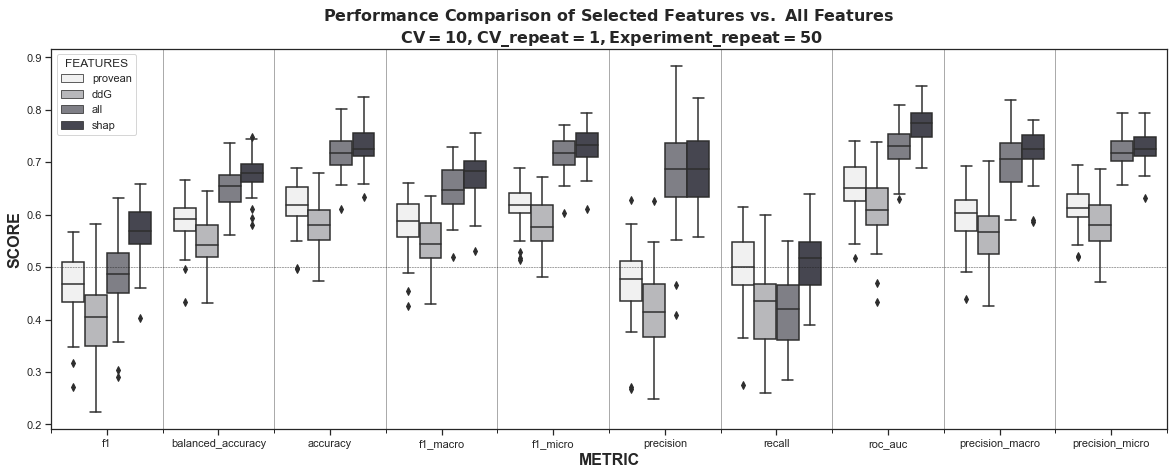

In [158]:
plt.figure(figsize=(20, 7))
plt.title('$\mathbf{Performance\ Comparison\ of\ Selected\ Features\ vs.\ All\ Features}$ \n ' + 
          '$\mathbf{CV=10, CV\_repeat=1, Experiment\_repeat = 50}$', fontsize=16, fontweight='bold')
plt.ylabel('Metrics', fontsize=16, fontweight='bold')
plt.xlabel('Scores', fontsize=16, fontweight='bold')
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.8, lw=0.5)
ax = sns.boxplot(x='METRIC', y='SCORE', hue='FEATURES', data=scoring_metrics_data, palette='light:#444452')  # bone, vlag, cividis, #03012d
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.grid(True, which='minor', color='#ababab', lw=1)
# plt.grid()
plt.show()
# sns.despine(offset=10, trim=True)

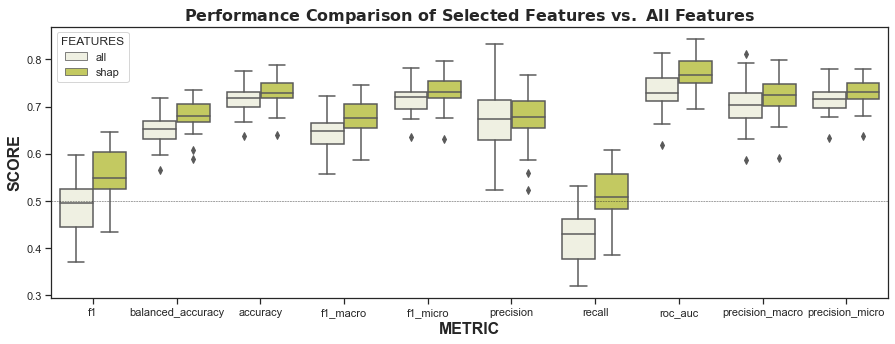

In [83]:
plt.figure(figsize=(15, 5))
plt.title(r'$\mathbf{Performance\ Comparison\ of\ Selected\ Features\ vs.\ All\ Features}$', fontsize=16, fontweight='bold')
plt.ylabel('Metrics', fontsize=16, fontweight='bold')
plt.xlabel('Scores', fontsize=16, fontweight='bold')
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.8, lw=0.5)
sns.boxplot(x='METRIC', y='SCORE', hue='FEATURES', data=scoring_metrics_data, palette='light:#d2db4f')
# plt.grid()
plt.show()
# sns.despine(offset=10, trim=True)

# Fine Tuning

Fine Tuning on 80% of data (training *set*)

In [159]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [160]:
len(Xs_train[0]), len(ys_train[0])

(131, 131)

In [161]:
len(Xs_valid[0]), len(ys_valid[0])

(33, 33)

In [162]:
Xs_train_shap = []
Xs_valid_shap = []

for i in range(NUM_EXPERIMENT_REPEAT):
    Xs_train_shap.append(Xs_train[i][highly_selected_10_features])
    Xs_valid_shap.append(Xs_valid[i][highly_selected_10_features])

In [163]:
Xs_train_shap[0].columns

Index(['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score',
       'Solvent_accessibility_wt', 'Matrix_score', 'Solvent_accessibility_mut',
       'van_der_waals_mut', 'Interactor_template_sequence_identity',
       'solvation_polar_wt'],
      dtype='object')

In [164]:
def get_randomized_search(random_seed):
    param_grid_randomized  = {'bootstrap': [True, False],
                          'max_depth': [2, 7, 12],
                          'max_features': ['auto', 'sqrt'],
                          'n_estimators': [200, 600, 1000, 1400, 1800]}

    forest_clf = RandomForestClassifier(random_state=42)

    randomized_search = RandomizedSearchCV(forest_clf, param_grid_randomized, n_iter=1,  ## TODO, change n_iter to 10, (or some other num.)
                                           random_state=random_seed,    
                                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=random_seed), 
                                           scoring='balanced_accuracy', 
                                           return_train_score=True, n_jobs=-1, verbose=0)
    
    return randomized_search

In [165]:
randomized_search_objects = []
for i in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    randomized_search = get_randomized_search(random_seeds[i])
    randomized_search_objects.append(randomized_search.fit(Xs_train_shap[i], ys_train[i]))

  0%|          | 0/50 [00:00<?, ?it/s]

In [166]:
experiment_repeat_to_randomized_search_info = {}

for i in range(NUM_EXPERIMENT_REPEAT):
    experiment_repeat_to_randomized_search_info[F'EXP_RUN_{i+1}'] = [randomized_search_objects[i].best_params_,
                                                                     randomized_search_objects[i].best_estimator_,
                                                                     randomized_search_objects[i].best_score_]
    
classifiers_attributes_data = pd.DataFrame(experiment_repeat_to_randomized_search_info, 
                                           index=['best_params_', 'best_estimator_', 'best_score_']).T

classifiers_attributes_data.to_csv('classifiers_attributes_data_1.csv')
classifiers_attributes_data

,best_params_,best_estimator_,best_score_
EXP_RUN_1,"{'n_estimators': 1400, 'max_features': 'auto',...","(DecisionTreeClassifier(max_depth=7, max_featu...",0.687639
EXP_RUN_2,"{'n_estimators': 1800, 'max_features': 'auto',...","(DecisionTreeClassifier(max_depth=2, max_featu...",0.62875
EXP_RUN_3,"{'n_estimators': 200, 'max_features': 'auto', ...","(DecisionTreeClassifier(max_depth=7, max_featu...",0.745833
EXP_RUN_4,"{'n_estimators': 600, 'max_features': 'auto', ...","(DecisionTreeClassifier(max_depth=2, max_featu...",0.692222
EXP_RUN_5,"{'n_estimators': 600, 'max_features': 'sqrt', ...","(DecisionTreeClassifier(max_depth=7, max_featu...",0.641944
EXP_RUN_6,"{'n_estimators': 600, 'max_features': 'auto', ...","(DecisionTreeClassifier(max_depth=12, max_feat...",0.669028
EXP_RUN_7,"{'n_estimators': 600, 'max_features': 'sqrt', ...","(DecisionTreeClassifier(max_depth=2, max_featu...",0.674444
EXP_RUN_8,"{'n_estimators': 1400, 'max_features': 'sqrt',...","(DecisionTreeClassifier(max_depth=2, max_featu...",0.652083
EXP_RUN_9,"{'n_estimators': 1400, 'max_features': 'sqrt',...","(DecisionTreeClassifier(max_depth=2, max_featu...",0.603472
EXP_RUN_10,"{'n_estimators': 1000, 'max_features': 'sqrt',...","(DecisionTreeClassifier(max_depth=2, max_featu...",0.645556


In [167]:
final_models = []
for search_obj in randomized_search_objects:
    final_models.append(search_obj.best_estimator_)

# Prediction on Cancer Data

## Declaring `X_brca`, `X_coad`, `X_ov`

**BRCA**

In [226]:
Xs_brca = []
for i in range(NUM_EXPERIMENT_REPEAT):
    Xs_brca.append(target_brca_data[highly_selected_10_features].copy(deep=True))
    
# for X_brca in Xs_brca:
#     print("Dataframe dimensions: {}".format(X_brca.shape))
#     print(X_brca.columns.to_list(), end='\n\n')
#     # display(X_brca.head(1))

## Predicting `BRCA`

In [169]:
sample_entry = Xs_brca[0].iloc[[0], :].copy()

In [170]:
final_models[i].predict(sample_entry)[0]

0

In [171]:
final_models[i].classes_

array([0, 1], dtype=int64)

In [172]:
final_models[i].predict_proba(sample_entry)[0][0]

0.5658308046540191

In [173]:
sample_entry_predictions = []
for i in range(NUM_EXPERIMENT_REPEAT):
    sample_entry_predictions.append(final_models[i].predict(sample_entry)[0])

In [174]:
sample_entry_predictions.count(0), sample_entry_predictions.count(1)

(39, 11)

In [175]:
sample_entry_probabilities = []  # for class 0.
for i in range(NUM_EXPERIMENT_REPEAT):
    sample_entry_probabilities.append(final_models[i].predict_proba(sample_entry)[0][0])

In [176]:
np.array(sample_entry_probabilities).mean()

0.5629294205477726

In [113]:
final_models[i].predict(Xs_brca[0].iloc[[965], :])

array([1], dtype=int64)

In [119]:
final_models[i].predict_proba(Xs_brca[0].iloc[[965], :])

array([[0.3914809, 0.6085191]])

In [114]:
Xs_brca[0].iloc[[965], :]

,Provean_score,EL2_score,Final_ddG,Interactor_alignment_score,Matrix_score,Solvent_accessibility_wt,Solvent_accessibility_mut,van_der_waals_mut,Interactor_template_sequence_identity,Model/DOPE_score
965,-2.797,-0.231162,0.39033,0.966473,2.0,25.5451,35.5295,-15.0974,0.9965,-0.318183


In [177]:
brca_predictions_list = []
for i in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    brca_predictions = final_models[i].predict(Xs_brca[i])
    brca_predictions_list.append(brca_predictions)

  0%|          | 0/50 [00:00<?, ?it/s]

In [180]:
predictions_value_counts = []
for i in range(NUM_EXPERIMENT_REPEAT):
    predictions_value_counts.append(
        (len(brca_predictions_list[i][brca_predictions_list[i]==0]), len(brca_predictions_list[i][brca_predictions_list[i]==1]))
    )

In [185]:
predictions_distributions_per_exp = pd.DataFrame(predictions_value_counts, index=[f'EXP_{i}' for i in range(1, NUM_EXPERIMENT_REPEAT + 1)])
predictions_distributions_per_exp.columns = ['Disrupting', 'NoEffect+Increasing']
predictions_distributions_per_exp['Total_entry'] = predictions_distributions_per_exp['Disrupting']\
                                                 + predictions_distributions_per_exp['NoEffect+Increasing']
predictions_distributions_per_exp.head()

,Disrupting,NoEffect+Increasing,Total_entry
EXP_1,2235,2217,4452
EXP_2,2720,1732,4452
EXP_3,2466,1986,4452
EXP_4,3167,1285,4452
EXP_5,2535,1917,4452


In [186]:
import matplotlib.pyplot as plt
import seaborn as sns

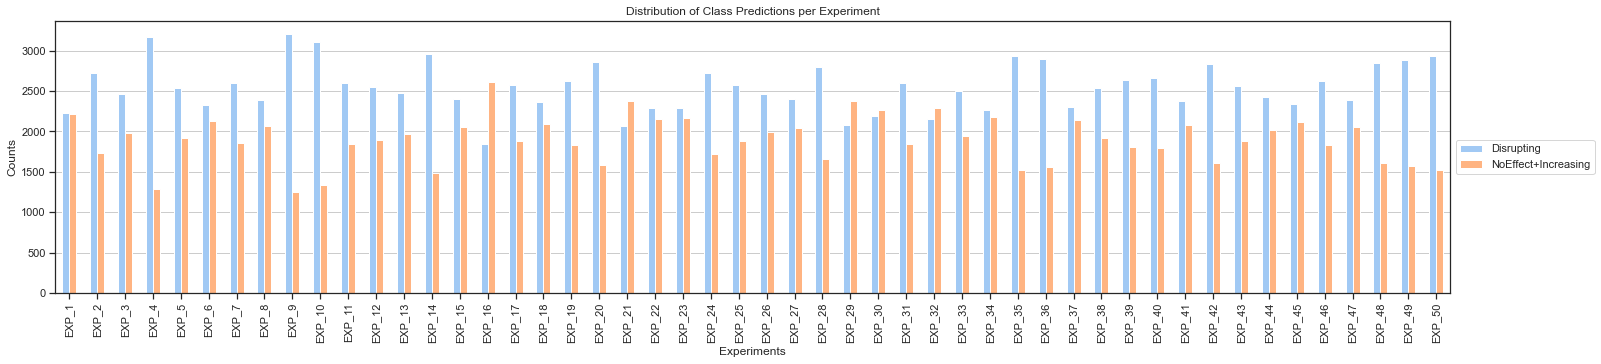

In [192]:
predictions_distributions_per_exp_table = predictions_distributions_per_exp.rename_axis('EXPERIMENT').reset_index()
predictions_distributions_per_exp_table
predictions_distributions_per_exp_table.plot(
    x="EXPERIMENT", y=["Disrupting", "NoEffect+Increasing"], kind="bar",
    figsize=(25, 5),
)
plt.grid(zorder=0, axis='y')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Distribution of Class Predictions per Experiment")
plt.xlabel("Experiments")
plt.ylabel("Counts")
plt.show()

In [ ]:
cancer_entries_probabilities = []  # for class 0.
for i in range(NUM_EXPERIMENT_REPEAT):
    cancer_entries_probabilities.append(final_models[i].predict_proba(sample_entry)[0][0])

In [194]:
Xs_brca[0].equals(Xs_brca[1])

True

# ========================

In [81]:
from collections import defaultdict
top_n_to_frequently_occurred_features = {}

for top_n, features_list in predator.shap_feature_selector.n_features_to_selected_features_list.items():
    selected_features_to_occurrences = defaultdict(int)
    for features in features_list:
        for feature in features:
            selected_features_to_occurrences[feature] += 1
            
    # Sorting the counts dictionary by value in desending order.
    frequently_occurred_features = sorted(selected_features_to_occurrences, 
                                          key=selected_features_to_occurrences.get, 
                                          reverse=True)[:top_n]
    
    top_n_to_frequently_occurred_features[top_n] = frequently_occurred_features

top_n: 3
top_n: 10


In [82]:
top_n_to_frequently_occurred_features.keys()

dict_keys([3, 10])

In [83]:
top_n_to_frequently_occurred_features[10]

['Provean_score',
 'EL2_score',
 'Final_ddG',
 'Interactor_alignment_score',
 'Matrix_score',
 'Solvent_accessibility_wt',
 'Solvent_accessibility_mut',
 'van_der_waals_mut',
 'Interactor_template_sequence_identity',
 'Model/DOPE_score']

In [84]:
top_n_to_frequently_occurred_features[3]

['Provean_score', 'EL2_score', 'Final_ddG']

In [85]:
debug_selected_features_to_occurrences_list[3]

defaultdict(int,
            {'Provean_score': 47,
             'EL2_score': 45,
             'Matrix_score': 3,
             'Final_ddG': 37,
             'Solvent_accessibility_wt': 4,
             'Solvent_accessibility_mut': 4,
             'Interactor_template_sequence_identity': 2,
             'Interactor_alignment_score': 4,
             'Interface_contact_distance_mut': 2,
             'solvation_polar_mut': 1,
             'van_der_waals_mut': 1})

In [100]:
debug_tuples = []
for k,v in debug_selected_features_to_occurrences_list[3].items():
    debug_tuples.append((k, v))

In [103]:
sorted(debug_tuples, key=lambda x: x[1], reverse=True)[:3]

[('Provean_score', 47), ('EL2_score', 45), ('Final_ddG', 37)]

In [101]:
[e[0] for e in sorted(debug_tuples, key=lambda x: x[1], reverse=True)[:3]]\
==top_n_to_frequently_occurred_features[3]

['Provean_score', 'EL2_score', 'Final_ddG']

In [ ]:
['Provean_score',
 'EL2_score',
 'Final_ddG',
 'Interactor_alignment_score',
 'Matrix_score',
 'Solvent_accessibility_wt',
 'Solvent_accessibility_mut',
 'van_der_waals_mut',
 'Interactor_template_sequence_identity',
 'Model/DOPE_score']

# --------------

In [36]:
# TRAIN
benchmark_columns = ['Provean', '$\Delta\Delta$G', 'All Columns']
for n in predator.shap_feature_selector.shap_top_ns:
    benchmark_columns.append(f"SHAP Columns ({n})")

Xs_benchmark_feature_names_to_dataframes_list = []
for exp in range(predator.n_experiment):
    Xs_benchmark_feature_names_to_dataframes = {
         f"X_train_exp_{exp}_provean": predator.data_materials["Xs_train_provean"][exp],
         f"X_train_exp_{exp}_ddG": predator.data_materials["Xs_train_ddG"][exp],
         f"X_train_exp_{exp}": predator.data_materials["Xs_train"][exp]
    }
    for n in predator.shap_feature_selector.shap_top_ns:
        Xs_benchmark_feature_names_to_dataframes.update({
            f"X_train_exp_{exp}_shap_{n}": predator.data_materials[f"Xs_train_shap_{n}"][exp]     
        })
        
    Xs_benchmark_feature_names_to_dataframes_list.append(Xs_benchmark_feature_names_to_dataframes)

In [37]:
len(Xs_benchmark_feature_names_to_dataframes_list)

50

In [38]:
len(Xs_benchmark_feature_names_to_dataframes_list[0])

7

In [39]:
Xs_benchmark_feature_names_to_dataframes_list[0].keys()

dict_keys(['X_train_exp_0_provean', 'X_train_exp_0_ddG', 'X_train_exp_0', 'X_train_exp_0_shap_5', 'X_train_exp_0_shap_10', 'X_train_exp_0_shap_15', 'X_train_exp_0_shap_20'])

In [40]:
Xs_benchmark_feature_names_to_dataframes_list[9]["X_train_exp_9_ddG"].head()

,Final_ddG
145,-0.487431
82,1.620810
48,1.128010
32,1.354890
10,0.272926


In [ ]:
# [TRAIN] now will all, repeat is 1
scoring_metrics_list = []
for exp in tqdm(range(predator.n_experiment)):
    scoring_metrics = evaluate_metrics(Xs_benchmark_feature_names_to_dataframes_list[exp], 
                                       predator.data_materials["ys_train"][exp], 
                                       n_repeats=3, n_jobs=-1, verbose=False)  # <-- repeat should be 10 in actual run.
    scoring_metrics_list.append(scoring_metrics)

  0%|          | 0/50 [00:00<?, ?it/s]

In [42]:
scoring_metrics_list[0]

,f1,balanced_accuracy,accuracy,f1_macro,f1_micro,precision,recall,roc_auc,precision_macro,precision_micro
X_train_exp_0_provean,0.4763,0.6333,0.6324,0.6098,0.6258,0.4500,0.52,0.6974,0.5555,0.6412
X_train_exp_0_ddG,0.4847,0.5508,0.5951,0.5541,0.5951,0.4444,0.42,0.6218,0.5736,0.5791
X_train_exp_0,0.6111,0.6183,0.7319,0.6632,0.7319,0.7000,0.44,0.7553,0.7034,0.7016
X_train_exp_0_shap_5,0.5115,0.6908,0.6863,0.6531,0.7154,0.6650,0.46,0.7558,0.6499,0.6802
X_train_exp_0_shap_10,0.5517,0.6539,0.7181,0.6661,0.7335,0.7314,0.54,0.7831,0.6941,0.7236
X_train_exp_0_shap_15,0.5938,0.6725,0.6951,0.6684,0.7093,0.7279,0.50,0.7700,0.7544,0.7181
X_train_exp_0_shap_20,0.6153,0.7019,0.7258,0.6537,0.7242,0.7100,0.60,0.8018,0.7367,0.7478


In [ ]:
# waiting for above.

In [42]:
for key in predator.data_materials.keys():
    if 'Xs' in key:
        print(key)
        assert len(predator.data_materials[key]) == predator.n_experiment
        for item in predator.data_materials[key]:
            assert type(item) == pd.DataFrame

Xs
Xs_train
Xs_valid
Xs_train_random
Xs_valid_random
Xs_shap_5
Xs_train_shap_5
Xs_valid_shap_5
Xs_provean
Xs_train_provean
Xs_ddG
Xs_train_ddG
Xs_shap_10
Xs_train_shap_10
Xs_valid_shap_10
Xs_shap_20
Xs_train_shap_20
Xs_valid_shap_20
Xs_shap_30
Xs_train_shap_30
Xs_valid_shap_30
Xs_shap_40
Xs_train_shap_40
Xs_valid_shap_40


In [43]:
# Melting the dataframe.
scoring_metrics_entries = []
for i in range(predator.n_experiment):
    scoring = scoring_metrics_list[i].copy()
    scoring.index.name = 'X_NAME'
    scoring.insert(0, 'FEATURES', benchmark_columns)
    scoring.insert(0, 'EXPERIMENT_NO', i)
    scoring.reset_index(inplace=True)
    scoring = scoring.melt(id_vars=["X_NAME", "FEATURES", "EXPERIMENT_NO"], 
                          var_name="METRIC", 
                          value_name="SCORE")
    scoring_metrics_entries.append(scoring)
    
scoring_metrics_data = pd.concat(scoring_metrics_entries, axis='rows')
print(scoring_metrics_data.shape)
scoring_metrics_data.head()

(3500, 5)


,X_NAME,FEATURES,EXPERIMENT_NO,METRIC,SCORE
0,X_train_exp_0_provean,Provean,0,f1,0.4763
1,X_train_exp_0_ddG,$\Delta\Delta$G,0,f1,0.4847
2,X_train_exp_0,All Columns,0,f1,0.6111
3,X_train_exp_0_shap_5,SHAP Columns (5),0,f1,0.5115
4,X_train_exp_0_shap_10,SHAP Columns (10),0,f1,0.5517


In [44]:
dataframes = []
for column in benchmark_columns:
    dataframes.append(
        (scoring_metrics_data[scoring_metrics_data['FEATURES'] == column]
         .groupby(by=['METRIC']).mean().drop(['EXPERIMENT_NO'], axis='columns')
         .rename(columns={'SCORE': column}))
    )

In [45]:
pd.concat(dataframes, axis='columns')

,Provean,$\Delta\Delta$G,All Columns,SHAP Columns (5),SHAP Columns (10),SHAP Columns (15),SHAP Columns (20)
METRIC,,,,,,,
accuracy,0.611374,0.591634,0.712702,0.715542,0.730888,0.731316,0.728656
balanced_accuracy,0.582430,0.556564,0.648508,0.670978,0.680748,0.678434,0.678346
f1,0.460642,0.406194,0.488468,0.534588,0.554180,0.538678,0.537582
f1_macro,0.570514,0.548374,0.641672,0.656380,0.673936,0.674422,0.670522
f1_micro,0.610680,0.592820,0.714082,0.713720,0.733706,0.726602,0.733386
precision,0.472196,0.432532,0.647876,0.643030,0.676616,0.680296,0.695942
precision_macro,0.580492,0.560608,0.696484,0.700126,0.725360,0.720702,0.727136
precision_micro,0.614918,0.592694,0.714622,0.712738,0.732264,0.728156,0.732636
recall,0.477900,0.435400,0.419700,0.494800,0.503500,0.484400,0.478000


In [ ]:
scoring_metrics_data

In [46]:
from matplotlib.ticker import MultipleLocator

In [47]:
sns.set_theme(style="ticks", palette="pastel")

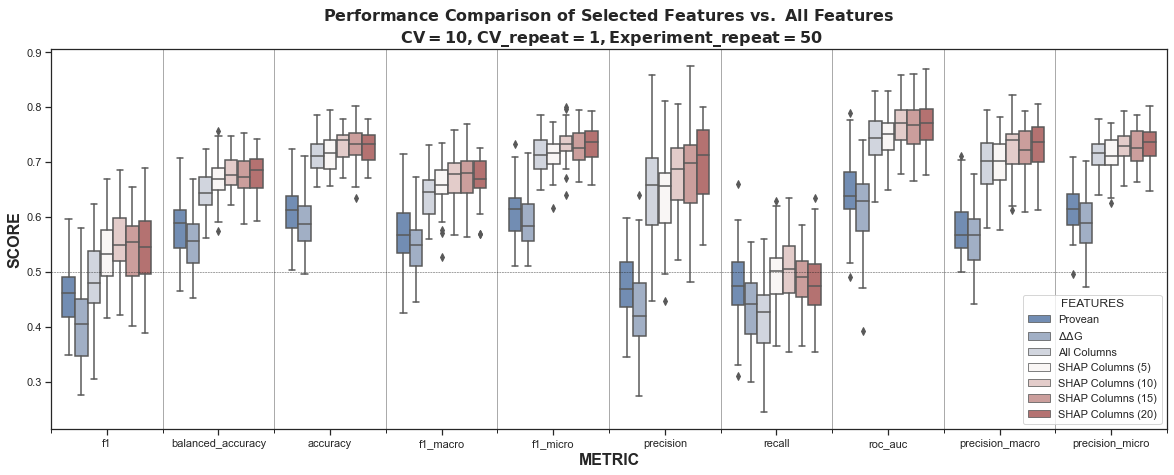

In [48]:
plt.figure(figsize=(20, 7))
plt.title('$\mathbf{Performance\ Comparison\ of\ Selected\ Features\ vs.\ All\ Features}$ \n ' + 
          '$\mathbf{CV=10, CV\_repeat=1, Experiment\_repeat = 50}$', fontsize=16, fontweight='bold')
plt.ylabel('Metrics', fontsize=16, fontweight='bold')
plt.xlabel('Scores', fontsize=16, fontweight='bold')
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.8, lw=0.5)
ax = sns.boxplot(x='METRIC', y='SCORE', hue='FEATURES', data=scoring_metrics_data, palette='vlag')  # bone, vlag, cividis, #03012d, light:#444452
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.grid(True, which='minor', color='#ababab', lw=1)
# plt.grid()
plt.show()
# sns.despine(offset=10, trim=True)

# --------

In [244]:
from timeit import default_timer as timer

In [255]:
trial = 20

default_times = []
for _ in tqdm(range(trial)):
    start_time = timer()
    clf = RandomForestClassifier(n_estimators=2000)
    clf.fit(Xs_train[0], ys_train[0])
    end_time = timer()
    elapsed_time = end_time - start_time
    default_times.append(elapsed_time)
    
n_jobs_times = []
for _ in tqdm(range(trial)):
    start_time = timer()
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=2000)
    clf.fit(Xs_train[0], ys_train[0])
    end_time = timer()
    elapsed_time = end_time - start_time
    n_jobs_times.append(elapsed_time)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [257]:
trial = 20

default_times = []
n_jobs_times = []

for i in tqdm(range(1, trial+1)):
    start_time = timer()
    clf = RandomForestClassifier(n_estimators=i * 100)
    clf.fit(Xs_train[0], ys_train[0])
    end_time = timer()
    elapsed_time = end_time - start_time
    default_times.append(elapsed_time)
    
    start_time = timer()
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=i * 100)
    clf.fit(Xs_train[0], ys_train[0])
    end_time = timer()
    elapsed_time = end_time - start_time
    n_jobs_times.append(elapsed_time)

  0%|          | 0/20 [00:00<?, ?it/s]

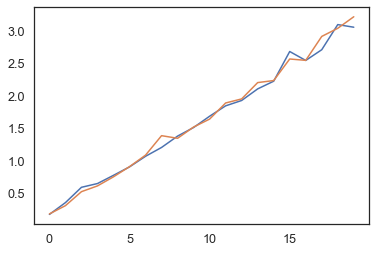

In [258]:
plt.plot(default_times)
plt.plot(n_jobs_times)

In [232]:
clf = RandomForestClassifier()

In [233]:
clf.fit(Xs_train[0], ys_train[0])

RandomForestClassifier()

In [242]:
clf.n_outputs_

1